* A - ширина пьедестала
* P - высота пьедестала в кПа
* unstable_mode - тор. номер наиболее неустойчивой моды
* growth - инкремент в обратных альфвеновских временах

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [2]:
index = pd.read_table("data/A.dat", sep=' ', header=None).to_numpy()[:, 0]
index

array([0.04500288, 0.05052546, 0.05605381, 0.06157635, 0.06710329,
       0.07262375, 0.07816408, 0.08369041, 0.08920925, 0.09472567,
       0.10025666, 0.10578876, 0.11132882, 0.11682243, 0.12235709,
       0.1279165 , 0.13343296, 0.13895064, 0.14447527, 0.150024  ])

In [3]:
header = pd.read_table("data/P.dat", sep=' ', header=None).to_numpy()[0]
header

array([0.3    , 0.57368, 0.84737, 1.12105, 1.39474, 1.66842, 1.94211,
       2.21579, 2.48947, 2.76316, 3.03684, 3.31053, 3.58421, 3.85789,
       4.13158, 4.40526, 4.67895, 4.95263, 5.22632, 5.5    ])

In [4]:
df = pd.read_table("data/growth.dat", sep=' ', header=None)
df_mode = pd.read_table("data/unstable_mode.dat", sep=' ', header=None)
# df_mode

In [5]:
# df = pd.read_clipboard()
# table = df.pivot('Y', 'X', 'Value')
data_arr = []
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        data_arr.append([index[i], header[j], df.iloc[i, j], df_mode.iloc[i, j]])

In [6]:
df_2 = pd.DataFrame(data_arr, columns=['A', 'P', 'growth', 'unstable_mode'])
# print(df_2)

In [7]:
import numpy as np

def smooth_steklov(y, box_pts, ro=0.1):
    c = 1 / 0.4439938161681
    x_ro = (np.arange(box_pts) - box_pts / 2) / (box_pts / 2 * ro)
    box = np.zeros(box_pts)
    box[abs(x_ro) < 1] = 1 / (box_pts / 2 * ro) * c * np.exp(1 / (x_ro[abs(x_ro) < 1] ** 2 - 1))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [20]:
np_growth = df_2.growth.to_numpy()
growth_edge = 0.1
zero_mask = abs(np_growth - growth_edge) < np_growth.std() / 4
plot_data = df_2.to_numpy()[zero_mask, :]

plot_x = [plot_data[0, 0]]
plot_y = [plot_data[0, 1]]
plot_z = [plot_data[0, 2]]
n_of_same_x = 1
for x, y, z in plot_data[1:, :3]:
    if x == plot_x[-1]:
        plot_y[-1] += y
        plot_z[-1] += z
        n_of_same_x += 1
    else:
        plot_y[-1] /= n_of_same_x
        plot_z[-1] /= n_of_same_x

        plot_x.append(x)
        plot_y.append(y)
        plot_z.append(z)
        n_of_same_x = 1

plot_y[-1] /= n_of_same_x
plot_z[-1] /= n_of_same_x
# print(zero_mask)

In [21]:
print(np_growth.std())

0.04093474510905184


In [22]:
# from scipy.interpolate import CubicSpline
#
# x, y = plot_data[:, 0], plot_data[:, 1]
# spl = CubicSpline(x, y)
#
# xnew = np.linspace(index.min(), index.max(), num=101)

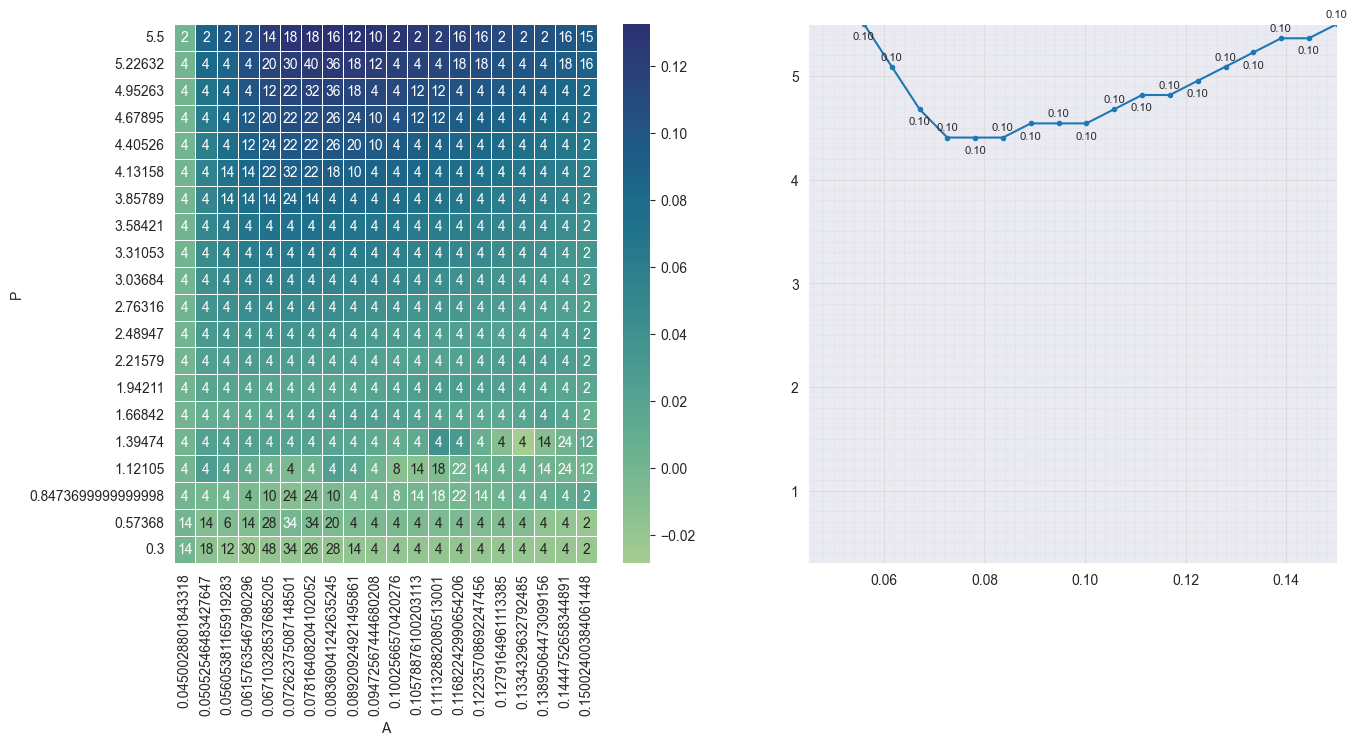

In [24]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_figwidth(15)
fig.set_figheight(7)

table = df_2.pivot(index='P', columns='A', values='growth')
annot_arr = df_mode.to_numpy()[1:, 1:]
# annot_arr[zero_mask] = -1
# print(table.shape, annot_arr.shape)

sns.heatmap(table, cmap="crest", annot=annot_arr.T, linewidth=.5, ax=ax1)
ax1.invert_yaxis()

# ax2.plot(plot_data[:, 0], plot_data[:, 1], marker="+", label='Direct', alpha=0.8)
# for i, (xi, yi) in enumerate(zip(plot_data[:, 0], plot_data[:, 1])):
#     ax2.annotate(f"{plot_data[i, 2]:.2f}",  # Текст аннотации
#                  (xi, yi),                # Координаты точки
#                  textcoords="offset points",  # Смещение текста
#                  fontsize=8,
#                  xytext=(-8, 5))

ax2.plot(plot_x, plot_y, marker=".")  # , label='Average', alpha=0.8, linewidth=.5
for i, (xi, yi) in enumerate(zip(plot_x, plot_y)):
    ax2.annotate(f"{plot_z[i]:.2f}",  # Текст аннотации
                 (xi, yi),                # Координаты точки
                 textcoords="offset points",  # Смещение текста
                 fontsize=8,
                 xytext=(-8, (5 if i%2 else -11)))

# ax2.legend()
ax2.set_xlim([df_2.A.min(), df_2.A.max()])
ax2.set_ylim([df_2.P.min(), df_2.P.max()])

ax2.grid(which='major', color='#DDDDDD', linewidth=0.9)
ax2.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.show()